In [28]:
import numpy as np
import networkx as nx

### Pagerank eigenvalue and iterative

$
L_1 =
    \begin{bmatrix}
        0 \\
        1 \\
        1 \\
    \end{bmatrix},
L_2 = 
    \begin{bmatrix}
        0 \\
        0 \\
        1 \\
    \end{bmatrix},
L_3 = 
    \begin{bmatrix}
        1 \\
        0 \\
        0 \\
    \end{bmatrix},
L =  
    \begin{bmatrix}
        0 & 0 & 1 \\
        1 & 0 & 0 \\
        1 & 1 & 0 \\
    \end{bmatrix},
R =  
    \begin{bmatrix}
        0 & 0 & 1 \\
        0.5 & 0 & 0 \\
        0.5 & 1 & 0 \\
    \end{bmatrix},
\vec{p} =
    \begin{bmatrix}
        0.667 \\
        0.333 \\
        0.667 \\
  \end{bmatrix}
$

In [24]:
def create_Rmatrix(L):
    """
    This matrix will take a L (NxN) matrix in and create a R matrix
    """
    #R = np.multiply(L, 1 / np.sum(L,axis=0)) # - faster runtime if no column is zero

    X = np.sum(L,axis=0)
    n_nodes = L.shape[0]
    R = np.zeros((n_nodes, n_nodes))
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            R[i,j] = L[i,j] / X[0,j] if X[0,j] != 0 else 0
            
    #R = np.multiply(L,R)
    return R

In [25]:
def pagerank_eigen(L, R=None):
    #Construct transition probability matrix from L
    if R is None: R = create_Rmatrix(L)
    #Compute eigen-vectors and eigen-values of R
    eigenvalues, eigenvectors = np.linalg.eig(R)
    #Take the eigen-vector with maximum eigven-value
    p = eigenvectors[:,np.argmax(np.absolute(eigenvalues))]
    return (R,p)

In [ ]:
def pagerank_iterative(L, R=None):
    if R is None: #We might want to compute R outside this function to avoid recomputing large matrix
        R = np.multiply(L, 1 / np.sum(L,axis=0))
    
    N = R.shape[0]
    e = np.ones(shape=(N,1))
    q = 0.9

    p = e
    delta = 1
    epsilon = 0.001
    i = 0
    while delta > epsilon:
        p_prev = p
        p = np.matmul(q * R, p_prev)
        p = p + (1-q) / N * e
        delta = np.linalg.norm(p-p_prev,1)
        i += 1

    print("Converged after {0} iterations".format(i))
    return R,p

In [26]:
L = np.matrix([
    [0,0,1], 
    [1,0,0], 
    [1,1,0]
])

create_Rmatrix(L)
pagerank_eigen(L);

### HITS Algorithm - hubs and authorities

In [ ]:
def hits_iterative(A, k = 10):
    N = A.shape[0]
    auth0, hub0 = 1 / (N*N) * np.ones(N), 1 / (N*N) * np.ones(N) 
    authprev, hubprev = auth0, hub0
    delta1 = delta2 = 1
    epsilon = 0.001 # We can strictly check for convergence rate of HITS algorithm
    l = 0
    while l < k and delta1 > epsilon and delta2 > epsilon:
        hub = np.matmul(A, authprev)
        auth = np.matmul(np.transpose(A), hub) 
        auth = auth / np.linalg.norm(auth,2)
        hub = hub / np.linalg.norm(hub,2)
        delta1 = np.linalg.norm(auth-authprev,1)
        delta2 = np.linalg.norm(hub-hubprev,1)
        authprev = auth
        hubprev = hub
        l += 1
    
    print("Ran a total of {0} iterations with the convergence rate delta1, delta2={1},{2}".format(l, delta1, delta2))
    return authprev, hubprev

### Modularity

In [27]:
import itertools
# The community label of a node can be accessed by G[node_id]['community']
# The degree of a node: G.degree[node_id]
# The neighbors of a node: G.neighbors(node_id)
# Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
def compute_modularity(G):
    m = len(G.edges)
    Q = 0
    nodes_dct = {}
    
    # Makes a nodes_dct: key: community | value: [list of nodes in community]
    for node in G.nodes:
        community = G.nodes[node]['community']
        if community in nodes_dct:
            current_list = nodes_dct[community]
            current_list.append(node)
            nodes_dct[community] = current_list
        else:
            nodes_dct[community] = [node]
            
    
    # number of links between nodes in module "S"    
    for community, value_list in nodes_dct.items():
        ls = 0
        ds = 0
        combinations = itertools.combinations(value_list, 2)
        # finds number of links between nodes in each module
        for subset in combinations: 
            links = G.number_of_edges(subset[0],subset[1])
            ls += links
        for node_id in value_list:
            ds += G.degree[node_id]
        Q += ls/m - (ds/(2*m))**2
                  
    return Q

### Betweenness centrality
Normalized: True/False

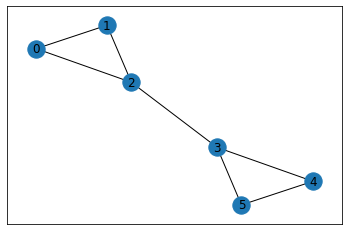

In [30]:
M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw_networkx(G)

In [31]:
nx.betweenness_centrality(G, k=1, normalized=True, weight=None,seed=None)
nx.edge_betweenness_centrality(G, k=None, normalized=False, weight=None,seed=None)

{(0, 1): 1.0,
 (0, 2): 4.0,
 (1, 2): 4.0,
 (2, 3): 9.0,
 (3, 4): 4.0,
 (3, 5): 4.0,
 (4, 5): 1.0}